In [1]:
'''Imports'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from ipywidgets import interact
from scipy import ndimage

In [2]:
load_path = "./Cleaned Data/Historical/"

In [3]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

### Data Import and Conversion

In [4]:
'''Data Import'''

#Precipitation
#Precip is in centimeters
precip = pd.read_csv(load_path + 'MEF_precipitation_daily.csv', 
                    parse_dates = ['DATE'])
precip['YEAR'] = precip.DATE.dt.year
precip['MONTH'] = precip.DATE.dt.month
precip['DOY'] = precip.DATE.dt.dayofyear

#Import Air Temperature
airTemp = pd.read_csv(load_path + 'MEF_airTemp_daily.csv', 
                    parse_dates = ['Date'])
airTemp['YEAR'] = airTemp.Date.dt.year
airTemp['MONTH'] = airTemp.Date.dt.month
airTemp['DOY'] = airTemp.Date.dt.dayofyear
airTemp = airTemp[airTemp.STATION == 'South'].reset_index(drop = True)

#Seasonal Soil Moisture
soilMoist = pd.read_csv(load_path + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

#Water Table
wteHist = pd.read_csv(load_path + 'MEF_daily_peatland_water_table.csv', 
                parse_dates = ['DATE'])
wte = wteHist[wteHist.PEATLAND == 'S2'].reset_index(drop = True)
wte['YEAR'] = wte.DATE.dt.year

#Streamflow
streamHist = pd.read_csv(load_path + 'S2_Breakpoint_streamflow.csv', 
                parse_dates = ['DateTime'])

#groupby date and average across timestamps
#streamflow interval is total streamflow over the timestamp in mm
streamHist['Year'] = streamHist.DateTime.dt.year
streamHist['Month'] = streamHist.DateTime.dt.month
streamHist['DOY'] = streamHist.DateTime.dt.dayofyear
streamHist_dailyflows = streamHist.groupby(['DOY', 'Year'])[['Stage.ft', 'Q.cfs', 'q.mmh', 'Month']].mean().reset_index(drop = False)
streamHist_dailyInterval = streamHist.groupby(['DOY', 'Year'])['q.interval'].sum().reset_index(drop = False)
streamHist_daily = pd.merge(streamHist_dailyInterval, streamHist_dailyflows, on = ['DOY', 'Year'])
streamHist_daily['q_interval_cm'] = streamHist_daily['q.interval']/10

In [5]:
'''Functions'''
import calendar
from functions import *

_MONTHDAYS = (31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
_LEAP_MONTHDAYS = (31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)


def thornthwaite(monthly_t, monthly_mean_dlh, year=None):
    """
    Estimate monthly potential evapotranspiration (PET) using the
    Thornthwaite (1948) method.

    Thornthwaite equation:

        *PET* = 1.6 (*L*/12) (*N*/30) (10*Ta* / *I*)***a*

    where:

    * *Ta* is the mean daily air temperature [deg C, if negative use 0] of the
      month being calculated
    * *N* is the number of days in the month being calculated
    * *L* is the mean day length [hours] of the month being calculated
    * *a* = (6.75 x 10-7)*I***3 - (7.71 x 10-5)*I***2 + (1.792 x 10-2)*I* + 0.49239
    * *I* is a heat index which depends on the 12 monthly mean temperatures and
      is calculated as the sum of (*Tai* / 5)**1.514 for each month, where
      Tai is the air temperature for each month in the year

    :param monthly_t: Iterable containing mean daily air temperature for each
        month of the year [deg C].
    :param monthly_mean_dlh: Iterable containing mean daily daylight
        hours for each month of the year (hours]. These can be calculated
        using ``monthly_mean_daylight_hours()``.
    :param year: Year for which PET is required. The only effect of year is
        to change the number of days in February to 29 if it is a leap year.
        If it is left as the default (None), then the year is assumed not to
        be a leap year.
    :return: Estimated monthly potential evaporation of each month of the year
        [mm/month]
    :rtype: List of floats
    """
    if len(monthly_t) != 12:
        raise ValueError(
            'monthly_t should be length 12 but is length {0}.'
            .format(len(monthly_t)))
    if len(monthly_mean_dlh) != 12:
        raise ValueError(
            'monthly_mean_dlh should be length 12 but is length {0}.'
            .format(len(monthly_mean_dlh)))

    if year is None or not calendar.isleap(year):
        month_days = _MONTHDAYS
    else:
        month_days = _LEAP_MONTHDAYS

    # Negative temperatures should be set to zero
    adj_monthly_t = [t * (t >= 0) for t in monthly_t]

    # Calculate the heat index (I)
    I = 0.0
    for Tai in adj_monthly_t:
        if Tai / 5.0 > 0.0:
            I += (Tai / 5.0) ** 1.514

    a = (6.75e-07 * I ** 3) - (7.71e-05 * I ** 2) + (1.792e-02 * I) + 0.49239

    pet = []
    for Ta, L, N in zip(adj_monthly_t, monthly_mean_dlh, month_days):
        # Multiply by 10 to convert cm/month --> mm/month
        pet.append(
            1.6 * (L / 12.0) * (N / 30.0) * ((10.0 * Ta / I) ** a) * 10.0)

    return pet

def monthly_mean_daylight_hours(latitude, year=None):
    """
    Calculate mean daylight hours for each month of the year for a given
    latitude.

    :param latitude: Latitude [radians]
    :param year: Year for the daylight hours are required. The only effect of
        *year* is to change the number of days in Feb to 29 if it is a leap
        year. If left as the default, None, then a normal (non-leap) year is
        assumed.
    :return: Mean daily daylight hours of each month of a year [hours]
    :rtype: List of floats.
    """
    check_latitude_rad(latitude)

    if year is None or not calendar.isleap(year):
        month_days = _MONTHDAYS
    else:
        month_days = _LEAP_MONTHDAYS
    monthly_mean_dlh = []
    doy = 1         # Day of the year
    for mdays in month_days:
        dlh = 0.0   # Cumulative daylight hours for the month
        for daynum in range(1, mdays + 1):
            sd = sol_dec(doy)
            sha = sunset_hour_angle(latitude, sd)
            dlh += daylight_hours(sha)
            doy += 1
        # Calc mean daylight hours of the month
        monthly_mean_dlh.append(dlh / mdays)
    return monthly_mean_dlh

In [6]:
#Convert Soil Moisture to PAW

#Refine to S2 and S6 measurements
sites = ['S2E', 'S2S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)].reset_index(drop = True)

    #test if bulktemp is at least one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

#PAW in cm
soilMoist_melt['PAW'] = PAW

#Add days 
soilMoist_melt['YEAR'] = soilMoist_melt.DATE.dt.year
soilMoist_melt['MONTH'] = soilMoist_melt.DATE.dt.month
soilMoist_melt['DOY'] = soilMoist_melt.DATE.dt.dayofyear

#Sum down the water column for each site/sample
soilMoist_avg = soilMoist_melt.groupby(['LOCATION', 'DATE', 'YEAR', 'MONTH', 'DOY'])['PAW'].sum().reset_index()

In [7]:
'''Convert all data to same timescale'''
SM = soilMoist_avg[(soilMoist_avg.YEAR > 1967) & (soilMoist_avg.YEAR < 2017)].reset_index(drop = True)
P = precip[(precip.YEAR > 1967) & (precip.YEAR < 2017)].reset_index(drop = True)
Q = streamHist_daily[(streamHist_daily.Year > 1967) & (streamHist_daily.Year < 2017)].reset_index(drop = True)
WTE = wte[(wte.YEAR > 1967) & (wte.YEAR < 2017)].reset_index(drop = True)
T = airTemp[(airTemp.YEAR > 1967) & (airTemp.YEAR < 2017)].reset_index(drop = True)

<Axes: xlabel='DATE', ylabel='South_PCP'>

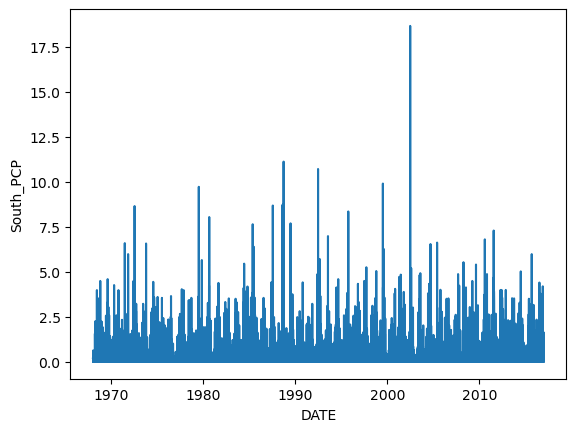

In [8]:
#Precip plot
sns.lineplot(data = P, x = 'DATE', y = 'South_PCP')

### Basic Budyko Curve (no storage assumption)

In [9]:
'''Compute Basic Budyko Curve'''
#Assume that ET = P - Q on an annual basis

#Aggregate P and Q to annual basis
P_annual = P.groupby(['YEAR'])[['South_PCP', 'NADP_PCP', 'North_PCP']].sum().reset_index()
Q_annual = Q.groupby(['Year'])['q_interval_cm'].sum().reset_index()

#Merge
annual_basicBC = pd.merge(P_annual, Q_annual, left_on = 'YEAR', right_on = 'Year')

#Compute ET
annual_basicBC['ET'] = annual_basicBC.South_PCP - annual_basicBC['q_interval_cm']

#Compute PET from PyETO package
ETmax = []
lat = deg2rad(47.5139)
for year in set(T.YEAR):
    temp = T[T.YEAR == year]
    mmdlh = monthly_mean_daylight_hours(lat, year)

    #groupby month for mean daily temp
    temp_monthly = temp.groupby(['MONTH'])[['MINC', 'MAXC']].mean().reset_index()
    temp_monthly['MEANC'] = (temp_monthly.MINC + temp_monthly.MAXC)/2
    monthly_t = list(temp_monthly.MEANC)
    monthly_et = thornthwaite(monthly_t, mmdlh)
    ETmax.append(np.max(monthly_et))

annual_basicBC['ETmax'] = ETmax

#Dryness Index and Storage Index
annual_basicBC['EP'] = annual_basicBC['ET']/annual_basicBC['South_PCP']
annual_basicBC['DI'] = annual_basicBC['ETmax']/annual_basicBC['South_PCP']

In [10]:
annual_basicBC.head()

,YEAR,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI
0,1968,89.59,0.0,92.30,1968,1.862934,87.727066,120.668943,0.979206,1.346902
1,1969,77.38,0.0,79.86,1969,2.034193,75.345807,125.467092,0.973712,1.621441
2,1970,67.09,0.0,66.64,1970,1.632906,65.457094,135.628627,0.975661,2.021592
3,1971,83.14,0.0,89.78,1971,1.733026,81.406974,117.927465,0.979155,1.418420
4,1972,80.34,0.0,87.05,1972,1.866032,78.473968,118.099232,0.976773,1.469993


C:\Users\marie\AppData\Local\Temp\ipykernel_20612\2361282755.py:6: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


Text(2, 0.1, 'Water Limit\nEnergy Limit')

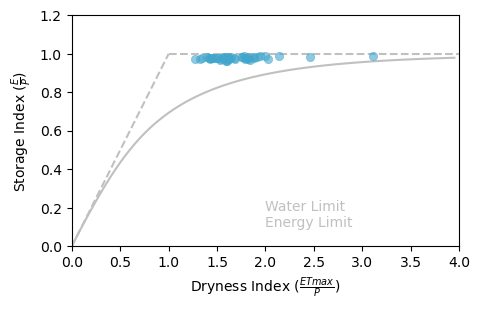

In [11]:
'''Plot Basic Budyko Curve'''
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

#Budyko Estimate
budyko_curve_x = np.arange(0, 4, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 4.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')

#Annual Water Balance Measurements
sns.scatterplot(data = annual_basicBC, x = 'DI', y = 'EP', 
                ax = ax, color = pal[3], edgecolor = None, alpha = 0.6,
                zorder = 3)

ax.set_xlim(0, 4)
ax.set_ylim(0, 1.2)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'Storage Index ($\frac{E}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

Bogs??? A water limited environment??? Absolutely not!!!

One reason for this is probably because we are using the max annual ETmax, which typically occurs in July/August but is by no means sustained year round. Therefore we are getting an outsized estimate of dryness in the system. Using mean annual ETmax doesn't really make sense either, we should instead complete this analysis on a seasonal basis.

### Budyko Curve with Storage Consideration

In [12]:
'''Storage Calculation'''
#Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
#Soil Moisture -- take the last measurement in a given year
SM_last = SM.sort_values(['DATE']).groupby(['YEAR', 'LOCATION']).tail(1).reset_index(drop = True)

#Compute difference over years by location
SM_last['deltaPAW'] = SM_last.groupby('LOCATION')['PAW'].diff()

#Average two sites
SM_last_avg = SM_last.groupby(['YEAR'])['deltaPAW'].mean().reset_index()

#Water Table -- take the measurement from January 1st
drainablePorosity = 0.57
WTE_last = WTE[WTE.DATE.dt.dayofyear == 1].reset_index(drop = True)
WTE_last['deltaWTE_length'] = WTE_last.WTE.diff()*100 #plus convert m to cm
WTE_last['deltaWTE'] = WTE_last.deltaWTE_length*drainablePorosity

#Compute a storage change by area
#S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
SM_last_avg['deltaPAW_watershed'] = SM_last_avg['deltaPAW']*650000000 
WTE_last['deltaWTE_watershed'] = WTE_last['deltaWTE']*320000000

#Merge data
storage = pd.merge(SM_last_avg, WTE_last, on = 'YEAR')
storage = storage.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

#Compute total storage change and re-normalize by area
storage['deltaS'] = storage.deltaPAW_watershed + storage.deltaWTE_watershed
storage['deltaS_cm'] = storage.deltaS/(650000000 + 320000000)
storage.head()

,YEAR,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969,-0.398326,-258911900.0,13.0,7.41,2.371200e+09,2.112288e+09,2.177617
2,1970,0.203254,132115100.0,2.0,1.14,3.648000e+08,4.969151e+08,0.512284
3,1971,0.014116,9175400.0,-5.0,-2.85,-9.120000e+08,-9.028246e+08,-0.930747
4,1972,-0.417576,-271424400.0,3.0,1.71,5.472000e+08,2.757756e+08,0.284305


In [13]:
'''Merge with original Budyko Curve data'''
#Merge
budyko = pd.merge(storage, annual_basicBC, on = 'YEAR')
budyko = budyko.drop(columns = ['NADP_PCP', 'North_PCP', 'Year'])

#Compute new ET/P metric (DI stays the same)
#ET is now P - Q - Storage
budyko['ET_storage'] = budyko.South_PCP - budyko.q_interval_cm - budyko.deltaS_cm
budyko['EP_storage'] = budyko.ET_storage/budyko.South_PCP
budyko.head()

,YEAR,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.59,1.862934,87.727066,120.668943,0.979206,1.346902,NaN,NaN
1,1969,-0.398326,-258911900.0,13.0,7.41,2.371200e+09,2.112288e+09,2.177617,77.38,2.034193,75.345807,125.467092,0.973712,1.621441,73.168190,0.945570
2,1970,0.203254,132115100.0,2.0,1.14,3.648000e+08,4.969151e+08,0.512284,67.09,1.632906,65.457094,135.628627,0.975661,2.021592,64.944810,0.968025
3,1971,0.014116,9175400.0,-5.0,-2.85,-9.120000e+08,-9.028246e+08,-0.930747,83.14,1.733026,81.406974,117.927465,0.979155,1.418420,82.337721,0.990350
4,1972,-0.417576,-271424400.0,3.0,1.71,5.472000e+08,2.757756e+08,0.284305,80.34,1.866032,78.473968,118.099232,0.976773,1.469993,78.189664,0.973235


C:\Users\marie\AppData\Local\Temp\ipykernel_20612\796563277.py:6: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


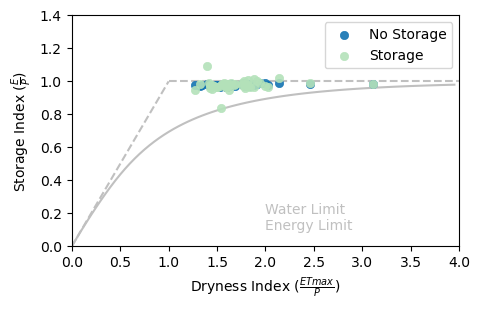

In [14]:
'''Plot Storage + Basic Budyko Curve'''
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

#Budyko Estimate
budyko_curve_x = np.arange(0, 4, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 4.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')

#Annual Water Balance Measurements
sns.scatterplot(data = budyko, x = 'DI', y = 'EP', 
                ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                label = 'No Storage',
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko, x = 'DI', y = 'EP_storage', 
                ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                label = 'Storage',
                zorder = 3)

ax.set_xlim(0, 4)
ax.set_ylim(0, 1.4)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'Storage Index ($\frac{E}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

plt.savefig('../Figures/HistoricalFigs/annualBudykoCurves.pdf', bbox_inches = 'tight')

### Budyko Curve with Adjustable start time

In [15]:
def leapYear(year):
    if (( year%400 == 0)or (( year%4 == 0 ) and ( year%100 != 0))):
        return True
    else:
        return False
    
def assignWaterYear(wyDate, dat, y_name, d_name):
    waterData = pd.DataFrame({'DOWY': range(0, len(dat)),
                              'WYEAR': range(0, len(dat))})
    
    for i in range(0, len(dat)):
        year = dat[y_name][i]
        
        if leapYear(year):
            waterData.DOWY[i] = (dat[d_name][i] - wyDate)%366
        
            if(dat[d_name][i] >= wyDate):
                waterData.WYEAR[i] = dat[y_name][i] + 1
            else:
                waterData.WYEAR[i] = dat[y_name][i]
        else:
            waterData.DOWY[i] = (dat[d_name][i] - wyDate)%365
            
            if(dat[d_name][i] >= wyDate):
                waterData.WYEAR[i] = dat[y_name][i] + 1
            else:
                waterData.WYEAR[i] = dat[y_name][i]
                
            
    return waterData.DOWY, waterData.WYEAR

@interact(date=(0,365))
def BudykoCurve(date):
    #Assign new year groupings according to the specified date of the year
    P['DOWY'], P['WYEAR'] = assignWaterYear(date, P, 'YEAR', 'DOY')
    Q['DOWY'], Q['WYEAR'] = assignWaterYear(date, Q, 'Year', 'DOY')
    T['DOWY'], T['WYEAR'] = assignWaterYear(date, T, 'YEAR', 'DOY')

    #Cut off incomplete years
    #SM = soilMoist_avg[(soilMoist_avg.YEAR > 1967) & (soilMoist_avg.YEAR < 2017)].reset_index(drop = True)
    P_trim = P[(P.WYEAR > 1968) & (P.WYEAR < 2017)].reset_index(drop = True)
    Q_trim = Q[(Q.WYEAR > 1968) & (Q.WYEAR < 2017)].reset_index(drop = True)
    #WTE = wte[(wte.YEAR > 1967) & (wte.YEAR < 2017)].reset_index(drop = True)
    T_trim = T[(T.WYEAR > 1968) & (T.WYEAR < 2017)].reset_index(drop = True)

    '''No Storage'''
    #Aggregate P and Q to annual basis
    P_annual_wy = P_trim.groupby(['WYEAR'])['South_PCP', 'NADP_PCP', 'North_PCP'].sum().reset_index()
    Q_annual_wy = Q_trim.groupby(['WYEAR'])['q_interval_cm'].sum().reset_index()

    #Merge
    annual_BC_wy = pd.merge(P_annual_wy, Q_annual_wy, on = 'WYEAR')

    #Compute ET
    annual_BC_wy['ET'] = annual_BC_wy.South_PCP - annual_BC_wy['q_interval_cm']

    #Compute PET from PyETO package
    ETmax = []
    lat = deg2rad(47.5139)
    for year in set(T_trim.WYEAR):
        temp = T_trim[T_trim.WYEAR == year]
        mmdlh = monthly_mean_daylight_hours(lat, year) #daylight hours should not change much from year to year

        #groupby month for mean daily temp
        temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
        temp_monthly['MEANC'] = (temp_monthly.MINC + temp_monthly.MAXC)/2
        monthly_t = list(temp_monthly.MEANC)
        monthly_et = thornthwaite(monthly_t, mmdlh)
        ETmax.append(np.max(monthly_et))

    annual_BC_wy['ETmax'] = ETmax

    #Dryness Index and Storage Index
    annual_BC_wy['EP'] = annual_BC_wy['ET']/annual_BC_wy['South_PCP']
    annual_BC_wy['DI'] = annual_BC_wy['ETmax']/annual_BC_wy['South_PCP']

    '''Storage'''
    #Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
    #Soil Moisture -- take the closest measurement to the selected date in each year
    SM['Date_delta'] = abs(SM.DOY - date)
    SM_sel = SM.sort_values(['Date_delta']).groupby(['YEAR', 'LOCATION']).first().reset_index()

    #Compute difference over years by location
    SM_sel['deltaPAW'] = SM_sel.groupby('LOCATION')['PAW'].diff()

    #Average two sites
    SM_sel_avg = SM_sel.groupby(['YEAR'])['deltaPAW'].mean().reset_index()

    #Water Table -- take the measurement from the specified date
    WTE_sel = WTE[WTE.DATE.dt.dayofyear == date].reset_index(drop = True)
    WTE_sel['deltaWTE'] = WTE_sel.WTE.diff()*100 #plus convert m to cm

    #Compute a storage change by area
    #S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
    SM_sel_avg['deltaPAW_watershed'] = SM_sel_avg['deltaPAW']*650000000 
    WTE_sel['deltaWTE_watershed'] = WTE_sel['deltaWTE']*320000000

    #Merge data
    storage_wy = pd.merge(SM_sel_avg, WTE_sel, on = 'YEAR')
    storage_wy = storage_wy.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

    #Compute total storage change and re-normalize by area
    storage_wy['deltaS'] = storage_wy.deltaPAW_watershed + storage.deltaWTE_watershed
    storage_wy['deltaS_cm'] = storage_wy.deltaS/(650000000 + 320000000)

    #Merge
    budyko_wy = pd.merge(storage, annual_BC_wy, left_on = 'YEAR', right_on = 'WYEAR')

    #Compute new ET/P metric (DI stays the same)
    #ET is now P - Q - Storage
    budyko_wy['ET_storage'] = budyko_wy.South_PCP - budyko_wy.q_interval_cm - budyko_wy.deltaS_cm
    budyko_wy['EP_storage'] = budyko_wy.ET_storage/budyko_wy.South_PCP

    '''Plot'''
    fig, ax = plt.subplots(1, 1, figsize = (5, 3))

    #Budyko Estimate
    budyko_curve_x = np.arange(0.005, 4, 0.05)
    budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
    sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
                ax = ax)

    #Energy and water limits
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    water_limit_x = np.arange(1, 4.0001, 0.05)
    water_limit_y = 1+water_limit_x*0
    energy_limit_y = energy_limit_x

    ax.plot(energy_limit_x, energy_limit_y, 
                color = 'silver', linestyle = '--')
    ax.plot(water_limit_x, water_limit_y, 
                color = 'silver', linestyle = '--')

    #Annual Water Balance Measurements
    sns.scatterplot(data = annual_BC_wy, x = 'DI', y = 'EP', 
                    ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                    label = 'No Storage',
                    zorder = 3)

    #Water Balance with Storage Consideration
    sns.scatterplot(data = budyko_wy, x = 'DI', y = 'EP_storage', 
                    ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                    label = 'Storage',
                    zorder = 3)

    ax.legend(loc = 'upper left')
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 1.4)
    ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
    ax.set_ylabel(r'$\frac{E}{P}$', rotation = 0, labelpad = 6)
    #ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

    print('Adjusted DOY to begin on: ' + str(date))

interactive(children=(IntSlider(value=182, description='date', max=365), Output()), _dom_classes=('widget-inte…

### Seasonal Budyko Storage Analysis

In [16]:
'''Add seasonal time components'''
#Spring --> will have deltaS values from over the snow season
#Fall --> will have deltaS values from over the growing season
SM['Season'] = ['Snow' if i < 6 else ('Growing' if i > 8 else 'Summer') for i in SM.MONTH]
WTE['Season'] = ['Snow' if i < 6 else ('Growing' if i > 8 else 'Summer') for i in WTE.DATE.dt.month]

#Remove summer soil moisture data -- not needed because there isn't enough of it
SM = SM[SM.Season != 'Summer']

In [17]:
'''Seasonal Storage Calculations'''
#Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
#Soil Moisture -- take the last measurement in a given year
SM_last_seasonal = SM.sort_values(['DATE']).groupby(['YEAR', 'Season', 'LOCATION']).tail(1).reset_index(drop = True)
#Compute difference over years by location
SM_last_seasonal['deltaPAW'] = SM_last_seasonal.groupby('LOCATION')['PAW'].diff()

#Average two sites
SM_last_seasonal_avg = SM_last_seasonal.groupby(['YEAR', 'Season'])['deltaPAW'].mean().reset_index()

#Water Table -- take the measurement from April 1st or October 1st
WTE_last_seasonal = WTE[(WTE.DATE.dt.dayofyear == 91) | (WTE.DATE.dt.dayofyear == 274)].reset_index(drop = True)
WTE_last_seasonal['deltaWTE_length'] = WTE_last_seasonal.WTE.diff()*100 #plus convert m to cm
WTE_last_seasonal['deltaWTE'] = WTE_last_seasonal.deltaWTE_length*drainablePorosity

#Compute a storage change by area
#S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
SM_last_seasonal_avg['deltaPAW_watershed'] = SM_last_seasonal_avg['deltaPAW']*650000000 
WTE_last_seasonal['deltaWTE_watershed'] = WTE_last_seasonal['deltaWTE']*320000000

#Merge data
storage_seasonal = pd.merge(SM_last_seasonal_avg, WTE_last_seasonal, on = ['YEAR', 'Season'])
storage_seasonal = storage_seasonal.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

#Compute total storage change and re-normalize by area
storage_seasonal['deltaS'] = storage_seasonal.deltaPAW_watershed + storage_seasonal.deltaWTE_watershed
storage_seasonal['deltaS_cm'] = storage_seasonal.deltaS/(650000000 + 320000000)
storage_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737


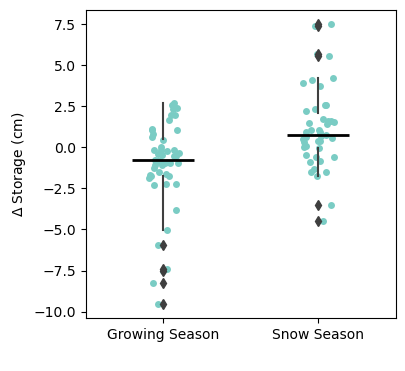

In [18]:
'''Plot Change in Storage'''
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.stripplot(data = storage_seasonal, x = 'Season', y = 'deltaS_cm', 
              color = pal[2], zorder = 0)
sns.boxplot(data = storage_seasonal, x = 'Season', y = 'deltaS_cm',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            width = 0.4, 
            ax = ax, zorder = 1)

ax.set_ylabel(r'$\Delta$ Storage (cm)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Growing Season', 'Snow Season'])

plt.savefig('../Figures/HistoricalFigs/seasonalStorageChange.pdf', bbox_inches = 'tight')

In [19]:
'''Compute Seasonal Climate Data'''
P['Season'] = ['Growing' if (i > 3) & (i < 11) else 'Snow' for i in P.MONTH]
Q['Season'] = ['Growing' if (i > 3) & (i < 11) else 'Snow' for i in Q.Month]


#Aggregate P and Q to seasonal basis
P_seasonal = P.groupby(['YEAR', 'Season'])[['South_PCP', 'NADP_PCP', 'North_PCP']].sum().reset_index()
Q_seasonal = Q.groupby(['Year', 'Season'])['q_interval_cm'].sum().reset_index()


#Merge
seasonal_basicBC = pd.merge(P_seasonal, Q_seasonal, left_on = ['YEAR', 'Season'], right_on = ['Year', 'Season'])


#Compute ET
seasonal_basicBC['ET'] = seasonal_basicBC.South_PCP - seasonal_basicBC['q_interval_cm']

#Compute PET from PyETO package
ETmax_growing = []
ETmax_winter = []
lat = deg2rad(47.5139)
for year in set(T.YEAR):
    temp = T[T.YEAR == year]
    mmdlh = monthly_mean_daylight_hours(lat, year)

    #groupby month for mean daily temp
    temp_monthly = temp.groupby(['MONTH'])[['MINC', 'MAXC']].mean().reset_index()
    temp_monthly['MEANC'] = (temp_monthly.MINC + temp_monthly.MAXC)/2
    monthly_t = list(temp_monthly.MEANC)
    monthly_et = thornthwaite(monthly_t, mmdlh)

    ETmax_growing.append(np.max(monthly_et[4:-2])) 
    ETmax_winter.append(np.max(monthly_et[0:4] + monthly_et[-2:]))


#Separate out to add ET
growingBC = seasonal_basicBC[seasonal_basicBC.Season == 'Growing']
growingBC['ETmax'] = ETmax_growing
winterBC = seasonal_basicBC[seasonal_basicBC.Season == 'Snow']
winterBC['ETmax'] = ETmax_winter

#Re-concatenate
basic_budyko = pd.concat([growingBC, winterBC])

#Dryness Index and Storage Index
basic_budyko['EP'] = basic_budyko['ET']/basic_budyko['South_PCP']
basic_budyko['DI'] = basic_budyko['ETmax']/basic_budyko['South_PCP']

basic_budyko.head()


C:\Users\marie\AppData\Local\Temp\ipykernel_20612\3835670698.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growingBC['ETmax'] = ETmax_growing
C:\Users\marie\AppData\Local\Temp\ipykernel_20612\3835670698.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winterBC['ETmax'] = ETmax_winter


,YEAR,Season,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI
0,1968,Growing,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540
2,1969,Growing,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227
4,1970,Growing,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744
6,1971,Growing,63.91,0.0,69.24,1971,1.546795,62.363205,117.927465,0.975797,1.845211
8,1972,Growing,64.95,0.0,70.82,1972,1.829777,63.120223,118.099232,0.971828,1.818310


In [20]:
storage_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737


In [21]:
'''Merge seasonal storage data with original Budyko Curve data'''
#Merge
budyko_seasonal = pd.merge(storage_seasonal, basic_budyko, on = ['YEAR', 'Season'])
#budyko_seasonal = budyko_seasonal.drop(columns = ['NADP_PCP', 'North_PCP', 'Year'])

#Compute new ET/P metric (DI stays the same)
#ET is now P - Q - Storage
budyko_seasonal['ET_storage'] = budyko_seasonal.South_PCP - budyko_seasonal.q_interval_cm - budyko_seasonal.deltaS_cm
budyko_seasonal['EP_storage'] = budyko_seasonal.ET_storage/budyko_seasonal.South_PCP
budyko_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540,71.396122,0.980716
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.0,17.72,1968,0.064699,16.725301,27.977955,0.996147,1.666346,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227,54.723446,0.948742
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.0,19.78,1969,0.151626,19.548374,33.093301,0.992303,1.679863,20.137115,1.022189
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744,52.862571,1.016783


C:\Users\marie\AppData\Local\Temp\ipykernel_20612\2117334893.py:9: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


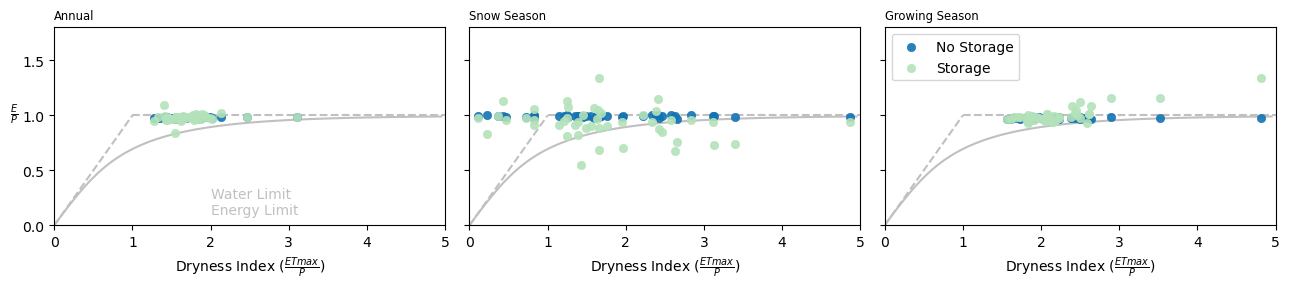

In [22]:
#Plot Seasonal Storage and no-storage Budyko
fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize = (13, 3), 
                            sharex = True, 
                            sharey = True, 
                            layout = 'tight')

#Budyko Estimate
budyko_curve_x = np.arange(0, 5, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 5.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

#Plot 1: Growing Season
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax3)
ax3.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax3.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')
#Annual Water Balance Measurements
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Growing'], x = 'DI', y = 'EP', 
                ax = ax3, color = pal[4], edgecolor = None, alpha = 0.9,
                label = 'No Storage',
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Growing'], x = 'DI', y = 'EP_storage', 
                ax = ax3, color = pal[1], edgecolor = None, alpha = 0.9,
                label = 'Storage',
                zorder = 3)
ax3.set_title('Growing Season', loc = 'left', fontsize = 'small')

#Plot 2: Winter Season
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax2)
ax2.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax2.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')
#Annual Water Balance Measurements
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Snow'], x = 'DI', y = 'EP', 
                ax = ax2, color = pal[4], edgecolor = None, alpha = 0.9,
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Snow'], x = 'DI', y = 'EP_storage', 
                ax = ax2, color = pal[1], edgecolor = None, alpha = 0.9,
                zorder = 3)
ax2.set_title('Snow Season', loc = 'left', fontsize = 'small')

#Plot 3: Annual 
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)
ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')
sns.scatterplot(data = budyko, x = 'DI', y = 'EP', 
                ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                zorder = 3)
sns.scatterplot(data = budyko, x = 'DI', y = 'EP_storage', 
                ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                zorder = 3)
ax.set_title('Annual', loc = 'left', fontsize = 'small')


ax.set_xlim(0, 5)
ax.set_ylim(0, 1.8)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'$\frac{E}{P}$', rotation = 0, labelpad = 6)
ax2.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax3.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

plt.savefig('../Figures/HistoricalFigs/seasonalBudykoCurves.pdf', bbox_inches = 'tight')

#### Storage Change source analysis

In [23]:
budyko_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540,71.396122,0.980716
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.0,17.72,1968,0.064699,16.725301,27.977955,0.996147,1.666346,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227,54.723446,0.948742
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.0,19.78,1969,0.151626,19.548374,33.093301,0.992303,1.679863,20.137115,1.022189
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744,52.862571,1.016783


In [24]:
#Subset and melt data for boxplots
budyko_seasonal_cm = budyko_seasonal[['YEAR', 'Season', 'deltaPAW', 'deltaWTE', 'deltaS_cm']]
budyko_seasonal_vol = budyko_seasonal[['YEAR', 'Season', 'deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS']]

budyko_seasonal_cm = budyko_seasonal_cm.melt(id_vars = ['YEAR', 'Season'], value_vars = ['deltaPAW', 'deltaWTE', 'deltaS_cm'])
budyko_seasonal_vol = budyko_seasonal_vol.melt(id_vars = ['YEAR', 'Season'], value_vars = ['deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS'])

budyko_seasonal_vol.head()

,YEAR,Season,variable,value
0,1968,Growing,deltaPAW_watershed,-200125900.0
1,1968,Snow,deltaPAW_watershed,NaN
2,1969,Growing,deltaPAW_watershed,-417432600.0
3,1969,Snow,deltaPAW_watershed,158520700.0
4,1970,Growing,deltaPAW_watershed,-397044700.0


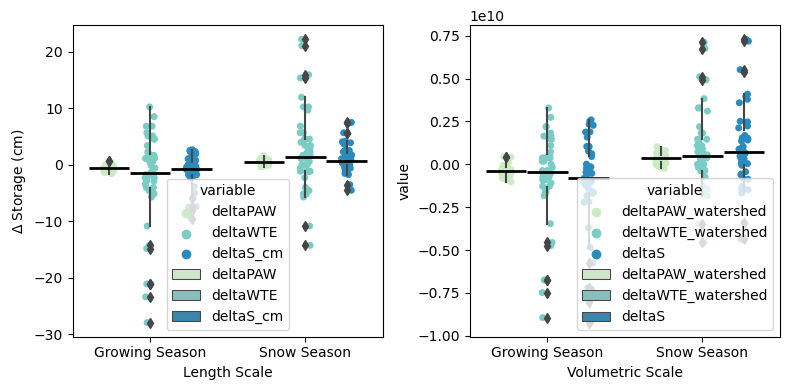

In [25]:
'''Plot Change in Storage'''
fig, [ax, ax1] = plt.subplots(1, 2, figsize = (8, 4), 
                                   sharex = True, 
                                   layout = 'tight')

sns.stripplot(data = budyko_seasonal_cm, x = 'Season', y = 'value', hue = 'variable',
            dodge = True, 
            palette = 'GnBu',
            zorder = 0, ax = ax)
sns.boxplot(data = budyko_seasonal_cm,  x = 'Season', y = 'value', hue = 'variable',
            showbox = False, showcaps = False, dodge = True,
            palette = 'GnBu',
            medianprops={"color": "k", "linewidth": 2}, 
            ax = ax, zorder = 1)

sns.stripplot(data = budyko_seasonal_vol, x = 'Season', y = 'value', hue = 'variable',
            dodge = True,
            palette = 'GnBu',
            zorder = 0, ax = ax1)
sns.boxplot(data = budyko_seasonal_vol,  x = 'Season', y = 'value', hue = 'variable',
            showbox = False, showcaps = False, 
            dodge = True,
            palette = 'GnBu',
            medianprops={"color": "k", "linewidth": 2}, 
            ax = ax1, zorder = 1)

ax.set_ylabel(r'$\Delta$ Storage (cm)')
ax.set_xlabel('Length Scale')
ax1.set_xlabel('Volumetric Scale')
ax.set_xticklabels(['Growing Season', 'Snow Season'])

plt.savefig('../Figures/HistoricalFigs/seasonalStorageBreakdown.pdf', bbox_inches = 'tight')

#### Merge with binning data for plotting storage by snow year

In [26]:
#Import Grand Rapids snow data
gr_snow = pd.read_csv(load_path + 'GR_ForestryLab_snow_daily.csv', 
                    parse_dates = ['Date'], 
                    header = 1, 
                    names = ["Date","MaxT_F","MinT_F","Precip_in","Snowfall_in","SnowDepth_in"], 
                    na_values = ['T', 'M', 'S'], 
                    dtype = {'Precip_in': np.float64})

#limit to years of interest
gr_snow = gr_snow[(gr_snow.Date.dt.year > 1961) & (gr_snow.Date.dt.year < 2024)].reset_index(drop = True)


gr_snow['Snowfall_SWE_in'] = np.where(gr_snow.Snowfall_in > 0, gr_snow.Precip_in, 0)

#Aggregate by year and find total inputs
gr_snow['Year'] = gr_snow.Date.dt.year

#groupby
gr_snow_annual = gr_snow.groupby(['Year'])[['Snowfall_in', 'Precip_in', 'Snowfall_SWE_in']].sum().reset_index(drop = False)

#Calculate snowfall fraction
gr_snow_annual['SnowFraction'] = gr_snow_annual.Snowfall_SWE_in/gr_snow_annual.Precip_in

#Bin by total annual snow inputs
gr_snow_annual['Fraction_Quants'] = pd.qcut(gr_snow_annual.SnowFraction, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
gr_snow_annual.head()

,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,SnowFraction,Fraction_Quants
0,1962,46.5,25.51,3.54,0.138769,LoSno
1,1963,43.6,25.33,4.22,0.166601,MedSno
2,1964,48.1,30.39,3.59,0.118131,LoSno
3,1965,88.6,32.37,7.90,0.244053,HighSno
4,1966,67.7,26.77,8.41,0.314158,HighSno


In [27]:
#Merge budyko data with binning
budyko_seasonal_binned = pd.merge(budyko_seasonal, gr_snow_annual[['Year', 'Fraction_Quants']], on = 'Year')
budyko_seasonal_binned = budyko_seasonal_binned.drop(columns = ['Year', 'North_PCP', 'NADP_PCP'])
budyko_seasonal_binned.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage,Fraction_Quants
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,1.798235,71.001765,120.668943,0.975299,1.657540,71.396122,0.980716,HighSno
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.064699,16.725301,27.977955,0.996147,1.666346,NaN,NaN,HighSno
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,1.882567,55.797433,125.467092,0.967362,2.175227,54.723446,0.948742,HighSno
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.151626,19.548374,33.093301,0.992303,1.679863,20.137115,1.022189,HighSno
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,1.417166,50.572834,135.628627,0.972742,2.608744,52.862571,1.016783,HighSno


C:\Users\marie\AppData\Local\Temp\ipykernel_20612\719676570.py:11: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\marie\AppData\Local\Temp\ipykernel_20612\719676570.py:11: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\marie\AppData\Local\Temp\ipykernel_20612\719676570.py:11: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\marie\AppData\Local\Temp\ipykernel_20612\719676570.py:11: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\marie\AppData\Local\Temp\ipykernel_20612\719676570.py:11: RuntimeWarning: divide by zero encoun

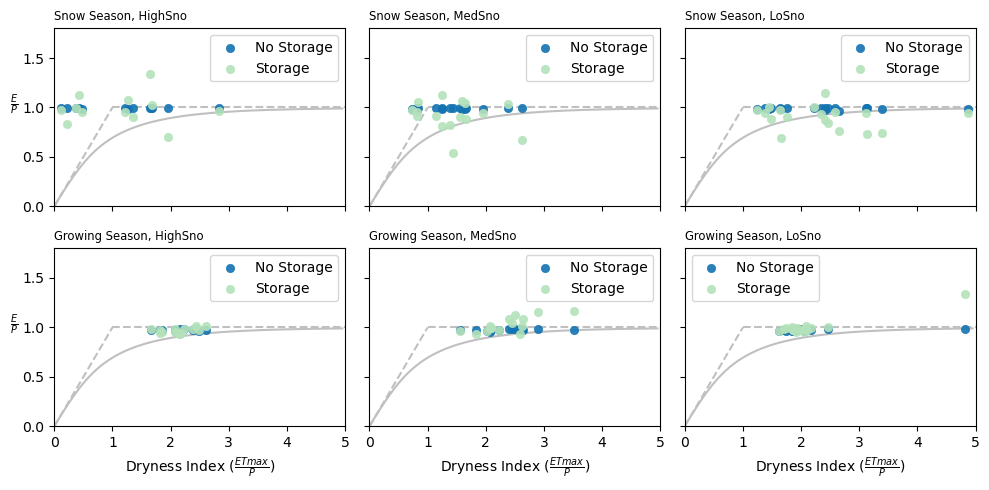

In [28]:
#Plot Budyko Curves by Snow Quantile
#Plot Seasonal Storage and no-storage Budyko
fig, axs = plt.subplots(2, 3, figsize = (10, 5), 
                            sharex = True, 
                            sharey = True, 
                            layout = 'tight')

def plotBudyko(dat, ax, label):
    #Budyko Estimate
    budyko_curve_x = np.arange(0, 5, 0.05)
    budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)

    #Energy and water limits
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    water_limit_x = np.arange(1, 5.0001, 0.05)
    water_limit_y = 1+water_limit_x*0
    energy_limit_y = energy_limit_x

    #plot base curve
    sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
                ax = ax)
    ax.plot(energy_limit_x, energy_limit_y, 
                color = 'silver', linestyle = '--')
    ax.plot(water_limit_x, water_limit_y, 
                color = 'silver', linestyle = '--')
    
    #Annual Water Balance Measurements
    sns.scatterplot(data = dat, x = 'DI', y = 'EP', 
                    ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                    label = 'No Storage',
                    zorder = 3)
    #Water Balance with Storage Consideration
    sns.scatterplot(data = dat, x = 'DI', y = 'EP_storage', 
                    ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                    label = 'Storage',
                    zorder = 3)
    ax.set_title(label, loc = 'left', fontsize = 'small')

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1.8)
    ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
    ax.set_ylabel(r'$\frac{E}{P}$', rotation = 0, labelpad = 6)

ax_array = axs.ravel()
ax_ind = 0
for season in ['Snow', 'Growing']:
    for snow in ['HighSno', 'MedSno', 'LoSno']:
        plotBudyko(budyko_seasonal_binned[(budyko_seasonal_binned.Season == season) & (budyko_seasonal_binned.Fraction_Quants == snow)], 
                   ax_array[ax_ind], 
                   label = season + ' Season, ' + snow)
        
        ax_ind = ax_ind +1


plt.savefig('../Figures/HistoricalFigs/seasonalBudykoCurves_withSnow.pdf', bbox_inches = 'tight')

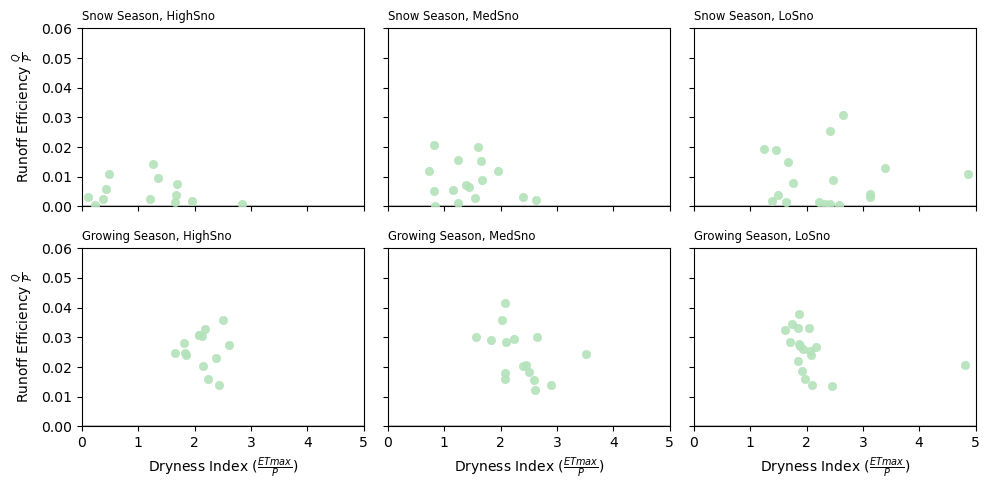

In [29]:
#Plot Budyko Curves by Snow Quantile
#Plot Seasonal Storage using delta Storage on the Y axis
budyko_seasonal_binned['SI'] = budyko_seasonal_binned.deltaS_cm/budyko_seasonal_binned.South_PCP
budyko_seasonal_binned['RE'] = budyko_seasonal_binned.q_interval_cm/budyko_seasonal_binned.South_PCP #Runoff Efficiency


fig, axs = plt.subplots(2, 3, figsize = (10, 5), 
                            sharex = True, 
                            sharey = True, 
                            layout = 'tight')

def plotBudykoStorageAxis(dat, ax, label):
    #Horizontal line at deltaS = a
    ax.axhline(y = 0, color = 'silver')
    
    #Annual Water Balance Measurements
    #Water Balance with Storage Consideration
    sns.scatterplot(data = dat, x = 'DI', y = 'RE', 
                    ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                    zorder = 3)
    ax.set_title(label, loc = 'left', fontsize = 'small')

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 0.06)
    ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
    ax.set_ylabel(r'Runoff Efficiency $\frac{Q}{P}$')

ax_array = axs.ravel()
ax_ind = 0
for season in ['Snow', 'Growing']:
    for snow in ['HighSno', 'MedSno', 'LoSno']:
        plotBudykoStorageAxis(budyko_seasonal_binned[(budyko_seasonal_binned.Season == season) & (budyko_seasonal_binned.Fraction_Quants == snow)], 
                   ax_array[ax_ind], 
                   label = season + ' Season, ' + snow)
        
        ax_ind = ax_ind +1

In [30]:
#Subset and melt data for boxplots
budyko_seasonal_binned_cm = budyko_seasonal_binned[['YEAR', 'Season', 'Fraction_Quants', 'deltaPAW', 'deltaWTE', 'deltaS_cm']]
budyko_seasonal_binned_vol = budyko_seasonal_binned[['YEAR', 'Season', 'Fraction_Quants', 'deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS']]

budyko_seasonal_binned_cm = budyko_seasonal_binned_cm.melt(id_vars = ['YEAR', 'Fraction_Quants', 'Season'], value_vars = ['deltaPAW', 'deltaWTE', 'deltaS_cm'])
budyko_seasonal_binned_vol = budyko_seasonal_binned_vol.melt(id_vars = ['YEAR', 'Fraction_Quants', 'Season'], value_vars = ['deltaPAW_watershed', 'deltaWTE_watershed', 'deltaS'])

budyko_seasonal_binned_vol.head()

,YEAR,Fraction_Quants,Season,variable,value
0,1968,HighSno,Growing,deltaPAW_watershed,-200125900.0
1,1968,HighSno,Snow,deltaPAW_watershed,NaN
2,1969,HighSno,Growing,deltaPAW_watershed,-417432600.0
3,1969,HighSno,Snow,deltaPAW_watershed,158520700.0
4,1970,HighSno,Growing,deltaPAW_watershed,-397044700.0


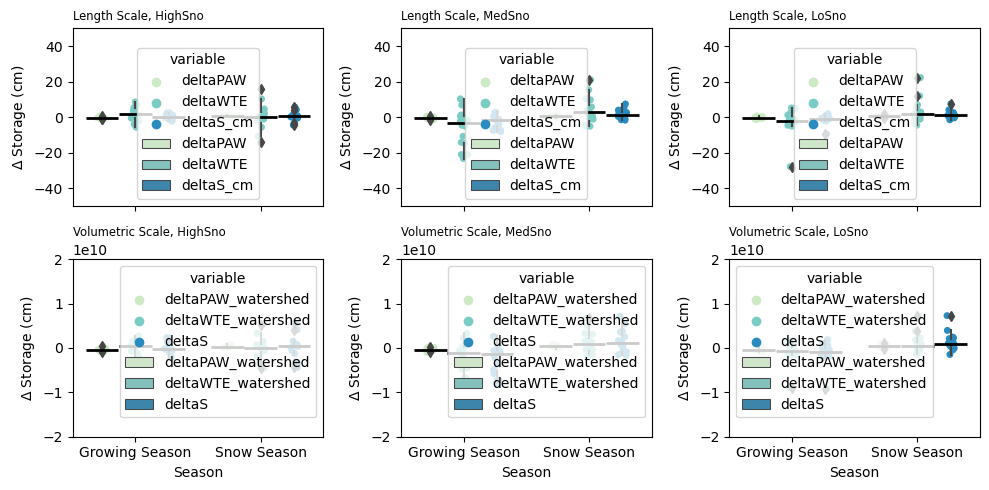

In [31]:
#Change in storage by snow regime
fig, axs = plt.subplots(2, 3, figsize = (10, 5), 
                                   sharex = True, 
                                   layout = 'tight')

def plotSeasonalStorage(dat, ax, label, length = False):
    sns.stripplot(data = dat, x = 'Season', y = 'value', hue = 'variable',
                dodge = True, 
                palette = 'GnBu',
                zorder = 0, ax = ax)
    sns.boxplot(data = dat,  x = 'Season', y = 'value', hue = 'variable',
                showbox = False, showcaps = False, dodge = True,
                palette = 'GnBu',
                medianprops={"color": "k", "linewidth": 2}, 
                ax = ax, zorder = 1)
    ax.set_ylabel(r'$\Delta$ Storage (cm)')
    ax.set_xticklabels(['Growing Season', 'Snow Season'])
    ax.set_title(label, loc = 'left', fontsize = 'small')

    if(length):
        ax.set_ylim(-50, 50)
    else:
        ax.set_ylim(-2e10, 2e10)

ax_array = axs.ravel()
ax_ind = 0
for type in ['Length', 'Volumetric']:
    for snow in ['HighSno', 'MedSno', 'LoSno']:
        if(type == 'Length'):
            plotSeasonalStorage(budyko_seasonal_binned_cm[budyko_seasonal_binned_cm.Fraction_Quants == snow], 
                ax_array[ax_ind], 
                label = 'Length Scale, ' + snow, 
                length = True)
        else:
            plotSeasonalStorage(budyko_seasonal_binned_vol[budyko_seasonal_binned_vol.Fraction_Quants == snow], 
                ax_array[ax_ind], 
                label = 'Volumetric Scale, ' + snow)
            
        ax_ind = ax_ind + 1

plt.savefig('../Figures/HistoricalFigs/seasonalStorageBreakdown_withSnow.pdf', bbox_inches = 'tight')

### Runoff Partition Analysis

In [32]:
#Lump current Budyko Data back with Peak SWE bins for bivariate analysis
gr_snow_annual['Input_Quants'] = pd.qcut(gr_snow_annual.Snowfall_in, 3, labels = ['LoSWE', 'MedSWE', 'HighSWE'])

partition = pd.merge(budyko_seasonal_binned, gr_snow_annual,
                    left_on = ['YEAR', 'Fraction_Quants'],
                    right_on = ['Year', 'Fraction_Quants'], how = 'outer')
partition = partition.drop(columns = ['YEAR'])

partition.head()

,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,q_interval_cm,...,EP_storage,Fraction_Quants,SI,RE,Year,Snowfall_in,Precip_in,Snowfall_SWE_in,SnowFraction,Input_Quants
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,LoSno,NaN,NaN,1962,46.5,25.51,3.54,0.138769,LoSWE
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MedSno,NaN,NaN,1963,43.6,25.33,4.22,0.166601,LoSWE
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,LoSno,NaN,NaN,1964,48.1,30.39,3.59,0.118131,LoSWE
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,HighSno,NaN,NaN,1965,88.6,32.37,7.90,0.244053,HighSWE
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,HighSno,NaN,NaN,1966,67.7,26.77,8.41,0.314158,HighSWE


In [33]:
#Divide into two quantiles
gr_snow_annual['Input_Quants_Duo'] = pd.qcut(gr_snow_annual.Snowfall_in, 2, labels = ['LoSWE', 'HighSWE'])
gr_snow_annual['Fraction_Quants_Duo'] = pd.qcut(gr_snow_annual.SnowFraction, 2, labels = ['LoFrac', 'HighFrac'])
gr_snow_annual['Precip_Quants_Duo'] = pd.qcut(gr_snow_annual.Precip_in, 2, labels = ['LoP', 'HighP'])

#Merge
partition_dual = pd.merge(budyko_seasonal_binned, gr_snow_annual,
                    left_on = ['YEAR', 'Fraction_Quants'],
                    right_on = ['Year', 'Fraction_Quants'], how = 'outer')

#Merge againg with temperature data
T['MEANC'] = (T.MAXC + T.MINC)/2
T_Annual = T.groupby('YEAR')['MEANC'].mean()
partition_dual = pd.merge(partition_dual, T_Annual,
                    on = ['YEAR'])
partition_dual = partition_dual.drop(columns = ['YEAR'])

#Temperature Quantiles
partition_dual['Temp_Quants_Duo'] = pd.qcut(partition_dual.MEANC, 2, labels = ['LoT', 'HighT'])

partition_dual

,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,q_interval_cm,...,Snowfall_in,Precip_in,Snowfall_SWE_in,SnowFraction,Input_Quants,Input_Quants_Duo,Fraction_Quants_Duo,Precip_Quants_Duo,MEANC,Temp_Quants_Duo
0,Growing,-0.307886,-2.001259e+08,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,1.798235,...,68.6,29.53,6.62,0.224179,HighSWE,HighSWE,HighFrac,HighP,3.077869,LoT
1,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.064699,...,68.6,29.53,6.62,0.224179,HighSWE,HighSWE,HighFrac,HighP,3.077869,LoT
2,Growing,-0.642204,-4.174326e+08,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,1.882567,...,73.6,26.81,7.01,0.261470,HighSWE,HighSWE,HighFrac,LoP,2.952055,LoT
3,Snow,0.243878,1.585207e+08,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.151626,...,73.6,26.81,7.01,0.261470,HighSWE,HighSWE,HighFrac,LoP,2.952055,LoT
4,Growing,-0.610838,-3.970447e+08,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,1.417166,...,76.0,24.87,6.95,0.279453,HighSWE,HighSWE,HighFrac,LoP,2.215068,LoT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Snow,1.013736,6.589284e+08,-8.0,-4.56,-1.459200e+09,-8.002716e+08,-0.825022,14.96,0.001379,...,59.9,28.60,5.71,0.199650,MedSWE,HighSWE,LoFrac,LoP,2.432219,LoT
91,Growing,-1.349340,-8.770710e+08,9.0,5.13,1.641600e+09,7.645290e+08,0.788174,63.74,0.882822,...,38.4,27.73,4.26,0.153624,LoSWE,LoSWE,LoFrac,LoP,5.155589,HighT
92,Snow,1.578892,1.026280e+09,-8.0,-4.56,-1.459200e+09,-4.329202e+08,-0.446309,21.46,0.405483,...,38.4,27.73,4.26,0.153624,LoSWE,LoSWE,LoFrac,LoP,5.155589,HighT
93,Growing,0.025146,1.634490e+07,-3.0,-1.71,-5.472000e+08,-5.308551e+08,-0.547273,62.39,1.127800,...,77.3,37.40,8.21,0.219519,HighSWE,HighSWE,HighFrac,HighP,5.540765,HighT


c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477142432964092, 0.14771844244839857, 0.1477088580031407)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.7529411764705882, 0.7529411764705882, 0.7529411764705882)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477142432964092, 0.14771844244839857, 0.1477088580031407)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavio

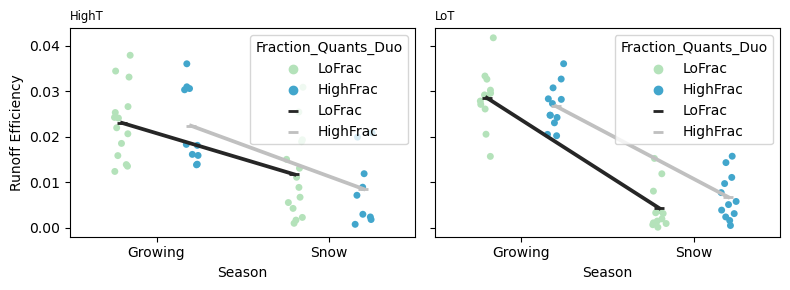

In [34]:
fig, axs = plt.subplots(1, 2, figsize = (8, 3), 
                               sharex=True, 
                               sharey=True, 
                               layout = 'tight')
ax_array = axs.ravel()
ax_ind = 0
for swe in set(partition_dual.Temp_Quants_Duo):
    sns.stripplot(data = partition_dual[partition_dual.Temp_Quants_Duo == swe], x = 'Season', y = 'RE',
                    dodge = True,
                    hue = 'Fraction_Quants_Duo',
                    palette = 'GnBu',
                    zorder = 0, ax = ax_array[ax_ind])
    sns.pointplot(data = partition_dual[partition_dual.Temp_Quants_Duo == swe], x="Season", y="RE",
                    hue = 'Fraction_Quants_Duo',
                    dodge = 0.4,
                    color = 'silver', errorbar=None,
                    ax = ax_array[ax_ind],
                    markers = '_')
    ax_array[ax_ind].set_ylabel(r'Runoff Efficiency')
    ax_array[ax_ind].set_xticklabels(['Growing', 'Snow'])
    ax_array[ax_ind].set_title(swe, size = 'small', loc = 'left')
    ax_ind = ax_ind + 1

    plt.savefig('../Figures/HistoricalFigs/RunoffEfficiency_Temp_PartitionBreakdown_Dual.pdf', bbox_inches = 'tight')

c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477142432964092, 0.14771844244839857, 0.1477088580031407)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.7529411764705882, 0.7529411764705882, 0.7529411764705882)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\marie\anaconda3\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.1477142432964092, 0.14771844244839857, 0.1477088580031407)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavio

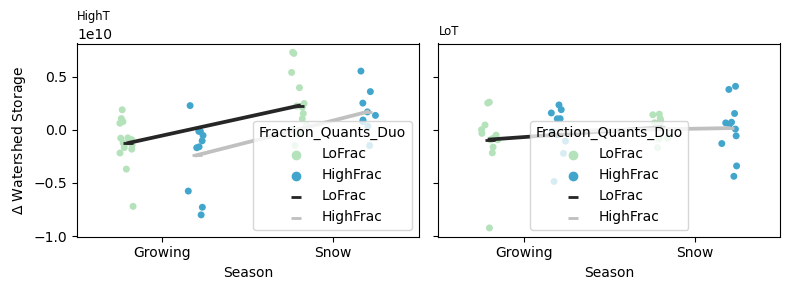

In [35]:
fig, axs = plt.subplots(1, 2, figsize = (8, 3), 
                               sharex=True, 
                               sharey=True, 
                               layout = 'tight')
ax_array = axs.ravel()
ax_ind = 0
for swe in set(partition_dual.Temp_Quants_Duo):
    sns.stripplot(data = partition_dual[partition_dual.Temp_Quants_Duo == swe], x = 'Season', y = 'deltaS',
                    dodge = True,
                    hue = 'Fraction_Quants_Duo',
                    palette = 'GnBu',
                    zorder = 0, ax = ax_array[ax_ind])
    sns.pointplot(data = partition_dual[partition_dual.Temp_Quants_Duo == swe], x="Season", y="deltaS",
                    hue = 'Fraction_Quants_Duo',
                    dodge = 0.4,
                    color = 'silver', errorbar=None,
                    ax = ax_array[ax_ind],
                    markers = '_')
    ax_array[ax_ind].set_ylabel(r'$\Delta$ Watershed Storage')
    ax_array[ax_ind].set_xticklabels(['Growing', 'Snow'])
    ax_array[ax_ind].set_title(swe, size = 'small', loc = 'left')
    ax_ind = ax_ind + 1

plt.savefig('../Figures/HistoricalFigs/StorageEfficiency_Temp_PartitionBreakdown_Dual.pdf', bbox_inches = 'tight')

## Statistics Section

### Time Series Analysis

In [36]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [37]:
budyko_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540,71.396122,0.980716
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.0,17.72,1968,0.064699,16.725301,27.977955,0.996147,1.666346,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227,54.723446,0.948742
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.0,19.78,1969,0.151626,19.548374,33.093301,0.992303,1.679863,20.137115,1.022189
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744,52.862571,1.016783


In [38]:
budyko_seasonal_cm.head()

,YEAR,Season,variable,value
0,1968,Growing,deltaPAW,-0.307886
1,1968,Snow,deltaPAW,NaN
2,1969,Growing,deltaPAW,-0.642204
3,1969,Snow,deltaPAW,0.243878
4,1970,Growing,deltaPAW,-0.610838


Text(0.0, 1.0, 'Total Storage')

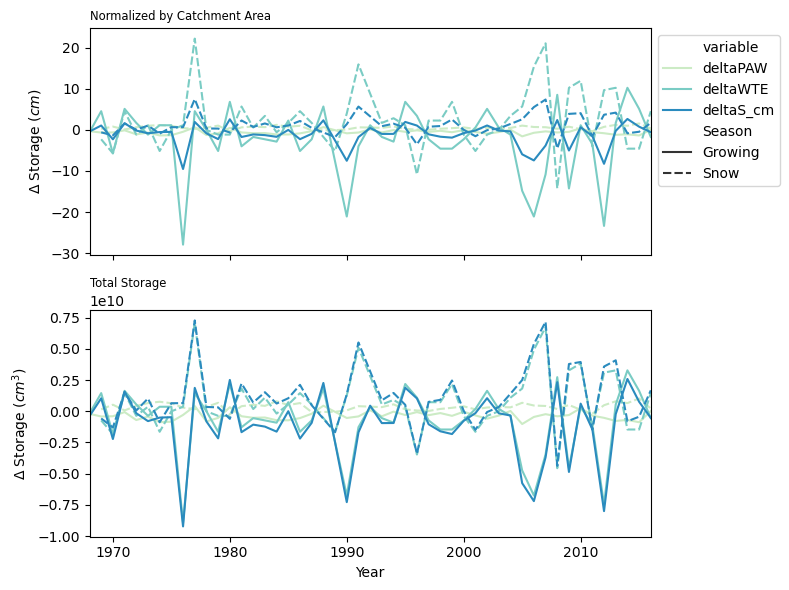

In [39]:
#Storage timeseries plots
fig, [ax, ax1] = plt.subplots(2, 1, figsize = (8, 6), 
                              sharex = True, 
                              layout = 'tight')

sns.lineplot(data = budyko_seasonal_cm, x = 'YEAR', y = 'value', 
             hue = 'variable', style = 'Season', 
             palette = 'GnBu', 
             ax = ax)

ax.set_ylabel(r'$\Delta$ Storage ($cm$)')
ax.set_title('Normalized by Catchment Area', loc = 'left', fontsize = 'small')
ax.legend(bbox_to_anchor = (1, 1))

sns.lineplot(data = budyko_seasonal_vol, x = 'YEAR', y = 'value', 
             hue = 'variable', style = 'Season', 
             palette = 'GnBu',
             legend = None, 
             ax = ax1)

ax1.set_xlim(min(budyko_seasonal.YEAR), max(budyko_seasonal.YEAR))
ax1.set_xlabel('Year')
ax1.set_ylabel(r'$\Delta$ Storage ($cm^3$)')
ax1.set_title('Total Storage', loc = 'left', fontsize = 'small')

Text(0.0, 1.0, 'Partial Autocorrelation, Snow Season')

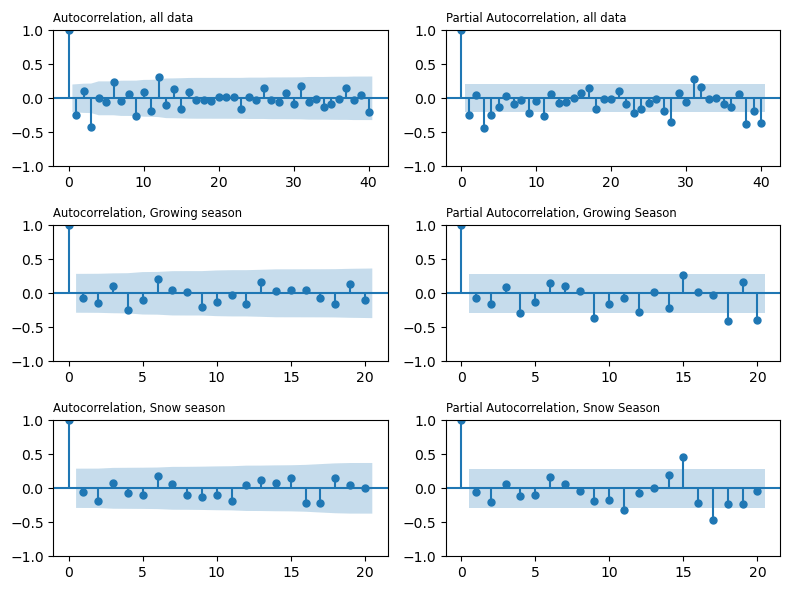

In [40]:
#Check time series autocorrelation plots for temporal independence
fig = plt.figure(figsize=(8, 6), 
                 layout = 'tight')
#All data - both seasons lumped 
ax1 = fig.add_subplot(321)
fig = sm.graphics.tsa.plot_acf(budyko_seasonal[budyko_seasonal.YEAR > 1968].deltaS.values.squeeze(), lags=40,
                            title = ' ',
                            ax=ax1)
ax1.set_title('Autocorrelation, all data', loc = 'left', fontsize = 'small')

ax2 = fig.add_subplot(322)
fig = sm.graphics.tsa.plot_pacf(budyko_seasonal[budyko_seasonal.YEAR > 1968].deltaS.values.squeeze(), lags=40,
                            title = ' ',
                            ax=ax2)
ax2.set_title('Partial Autocorrelation, all data', loc = 'left', fontsize = 'small')

#Just growing seasons
ax3 = fig.add_subplot(323)
fig = sm.graphics.tsa.plot_acf(budyko_seasonal[(budyko_seasonal.YEAR > 1968) & (budyko_seasonal.Season == 'Growing')].deltaS.values.squeeze(), lags=20,
                            title = ' ',
                            ax=ax3)
ax3.set_title('Autocorrelation, Growing season', loc = 'left', fontsize = 'small')

ax4 = fig.add_subplot(324)
fig = sm.graphics.tsa.plot_pacf(budyko_seasonal[(budyko_seasonal.YEAR > 1968) & (budyko_seasonal.Season == 'Growing')].deltaS.values.squeeze(), lags=20,
                            title = ' ',
                            ax=ax4)
ax4.set_title('Partial Autocorrelation, Growing Season', loc = 'left', fontsize = 'small')

#Just snow seasons
ax5 = fig.add_subplot(325)
fig = sm.graphics.tsa.plot_acf(budyko_seasonal[(budyko_seasonal.YEAR > 1968) & (budyko_seasonal.Season == 'Snow')].deltaS.values.squeeze(), lags=20,
                            title = ' ',
                            ax=ax5)
ax5.set_title('Autocorrelation, Snow season', loc = 'left', fontsize = 'small')

ax6 = fig.add_subplot(326)
fig = sm.graphics.tsa.plot_pacf(budyko_seasonal[(budyko_seasonal.YEAR > 1968) & (budyko_seasonal.Season == 'Snow')].deltaS.values.squeeze(), lags=20,
                            title = ' ',
                            ax=ax6)
ax6.set_title('Partial Autocorrelation, Snow Season', loc = 'left', fontsize = 'small')

### Information Theory

In [41]:
import dit

In [42]:
#Drop nan
budyko_seasonal_nan = budyko_seasonal.dropna(how = 'any')

#Sort seasons appropriately
storage_it = budyko_seasonal_nan.sort_values(['YEAR', 'Season'], ascending=[True, False])
storage_it.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE_length,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,Growing,-0.307886,-200125900.0,-1.0,-0.57,-1.824000e+08,-3.825259e+08,-0.394357,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540,71.396122,0.980716
3,1969,Snow,0.243878,158520700.0,-4.0,-2.28,-7.296000e+08,-5.710793e+08,-0.588742,19.70,0.0,19.78,1969,0.151626,19.548374,33.093301,0.992303,1.679863,20.137115,1.022189
2,1969,Growing,-0.642204,-417432600.0,8.0,4.56,1.459200e+09,1.041767e+09,1.073987,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227,54.723446,0.948742
5,1970,Snow,0.814092,529159800.0,-10.0,-5.70,-1.824000e+09,-1.294840e+09,-1.334887,15.10,0.0,15.51,1970,0.215740,14.884260,19.093693,0.985713,1.264483,16.219146,1.074116
4,1970,Growing,-0.610838,-397044700.0,-10.0,-5.70,-1.824000e+09,-2.221045e+09,-2.289737,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744,52.862571,1.016783


In [43]:
#Calculating join entropies
#dit.entropy([budyko_seasonal_nan.])